In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Load trades data
trades = pd.read_csv("historical_data.csv")
trades.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
trades["timestamp_ist"] = pd.to_datetime(trades["timestamp_ist"], errors="coerce")
trades = trades.dropna(subset=["execution_price", "size_usd", "closed_pnl"]).drop_duplicates()
trades

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0000,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211219,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.1010,382.20,420.80,SELL,NaT,7546.600000,Close Long,-20.2566,0xcd339c08dc7b615a993c0422374d8e02027400092bc2...,88803313862,False,0.042080,1.990000e+14,1.750000e+12
211220,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.1010,2124.10,2338.63,SELL,NaT,7164.400000,Close Long,-112.5773,0x29e8ede2a3a37aa0eac00422374d8e02029b00ac9f3c...,88803313862,False,0.233863,9.260000e+14,1.750000e+12
211221,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.1010,423.40,466.16,SELL,NaT,5040.300000,Close Long,-22.4402,0x0780085b0c0a943eea800422374d920204c100edf579...,88803313862,False,0.046616,6.930000e+14,1.750000e+12
211222,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,FARTCOIN,1.1010,3599.80,3963.38,SELL,NaT,4616.900000,Close Long,-190.7894,0x349c29934913b25c89e20422374d920204cd008b8a0e...,88803313862,False,0.396337,4.180000e+14,1.750000e+12


In [ ]:
# Load fear data
fear = pd.read_csv("fear_greed_index.csv")
fear.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
fear["date"] = pd.to_datetime(fear["date"], errors="coerce")
fear = fear.dropna(subset=["date", "classification"]).drop_duplicates()
fear

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05
...,...,...,...,...
2639,1745818200,54,Neutral,2025-04-28
2640,1745904600,60,Greed,2025-04-29
2641,1745991000,56,Greed,2025-04-30
2642,1746077400,53,Neutral,2025-05-01


In [ ]:
# Prepare date columns for merging
trades["trade_date"] = trades["timestamp_ist"].dt.date
fear["classification_date"] = fear["date"].dt.date

# Merge datasets on date
merged = pd.merge(
    trades,
    fear[["classification_date", "classification"]],
    left_on="trade_date",
    right_on="classification_date",
    how="left"
)

In [ ]:
# Summary statistics by classification
print(merged.groupby("classification")[["closed_pnl", "execution_price", "size_usd"]].describe())

               closed_pnl                                               \
                    count        mean          std            min  25%   
classification                                                           
Extreme Fear       2326.0    1.891632    76.727713   -1430.889856  0.0   
Extreme Greed      5621.0  205.816345  1861.557119  -18360.670070  0.0   
Fear              13869.0  128.287950  1342.348497  -19841.240140  0.0   
Greed             11292.0   53.988003  1399.468182 -117990.104100  0.0   
Neutral            2756.0   27.088803   142.945889   -1032.981540  0.0   

                                                 execution_price  \
                    50%        75%           max           count   
classification                                                     
Extreme Fear    0.00000   0.298102   2020.000000          2326.0   
Extreme Greed   0.96048  30.153710  44223.451870          5621.0   
Fear            0.00000   8.201820  71535.716740         13869.0   

C:\Users\aryan\AppData\Local\Temp\ipykernel_14724\2971248252.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="classification", y="closed_pnl", data=merged, inner="quartile", palette="muted")


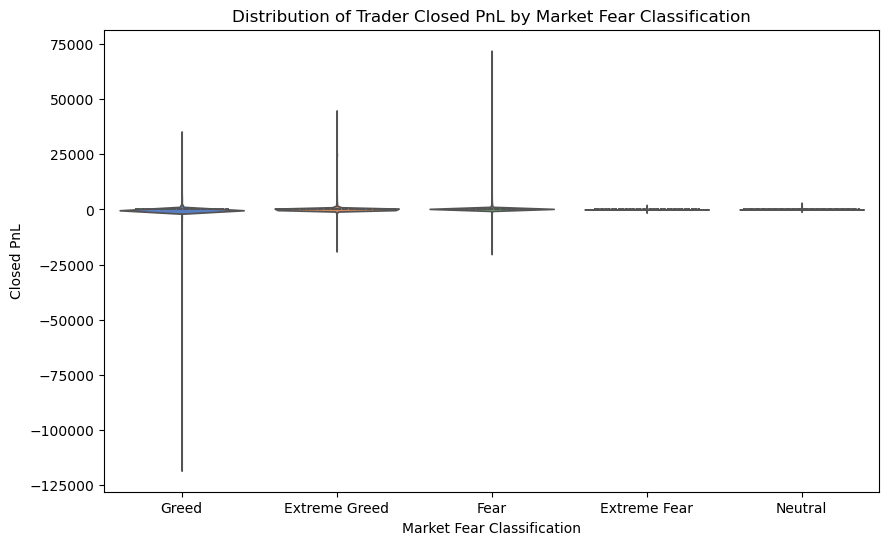

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="classification", y="closed_pnl", data=merged, inner="quartile", palette="muted")
plt.title("Distribution of Trader Closed PnL by Market Fear Classification")
plt.xlabel("Market Fear Classification")
plt.ylabel("Closed PnL")
plt.show()


C:\Users\aryan\AppData\Local\Temp\ipykernel_14724\890529634.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="classification", y="closed_pnl", data=merged, jitter=0.3, alpha=0.6, palette="Set2")


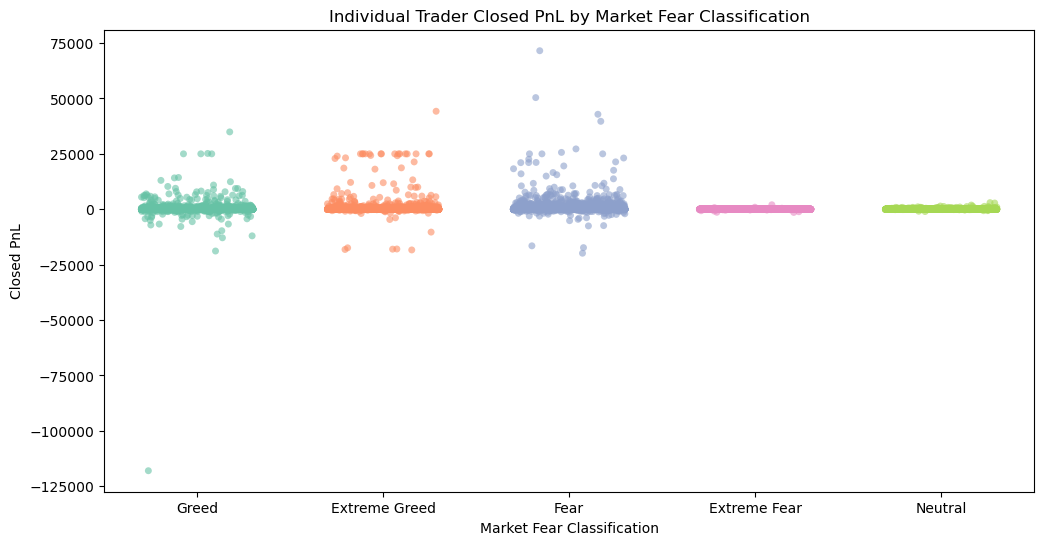

In [ ]:
plt.figure(figsize=(12, 6))
sns.stripplot(x="classification", y="closed_pnl", data=merged, jitter=0.3, alpha=0.6, palette="Set2")
plt.title("Individual Trader Closed PnL by Market Fear Classification")
plt.xlabel("Market Fear Classification")
plt.ylabel("Closed PnL")
plt.show()

C:\Users\aryan\AppData\Local\Temp\ipykernel_14724\1603452804.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Classification", loc="upper right")


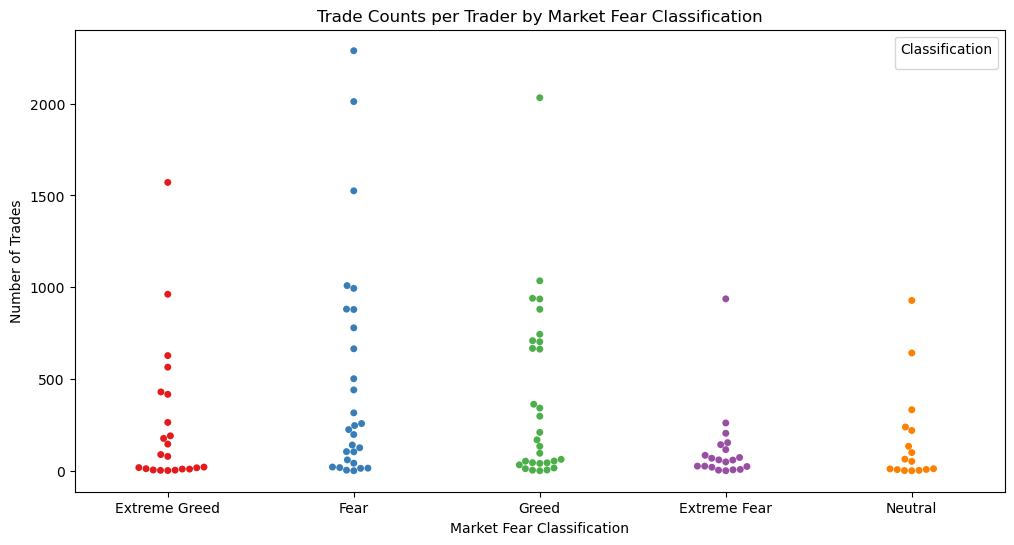

In [ ]:
# Aggregate number of trades per account per classification
trades_per_class = merged.groupby(["account", "classification"]).size().reset_index(name="trade_count")

plt.figure(figsize=(12, 6))
sns.swarmplot(x="classification", y="trade_count", data=trades_per_class, hue="classification", dodge=False, palette="Set1")
plt.title("Trade Counts per Trader by Market Fear Classification")
plt.xlabel("Market Fear Classification")
plt.ylabel("Number of Trades")
plt.legend(title="Classification", loc="upper right")
plt.show()


In [ ]:
# T-test for closed_pnl differences
fear_pnl = merged[merged["classification"]=="Fear"]["closed_pnl"]
greed_pnl = merged[merged["classification"]=="Greed"]["closed_pnl"]
t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, equal_var=False, nan_policy="omit")
print(f"T-test: t={t_stat:.4f}, p={p_val:.4e}")

T-test: t=4.2659, p=1.9991e-05


In [ ]:
# Overall aggregates per account
overall = merged.groupby("account").agg(
    total_closed_pnl=("closed_pnl", "sum"),
    avg_trade_size=("size_usd", "mean"),
    num_trades=("trade_id", "count"),
    win_rate=("closed_pnl", lambda x: (x > 0).mean())
).reset_index()

# Fear-specific averages and counts
fear = merged[merged["classification"] == "Fear"].groupby("account").agg(
    fear_avg_pnl=("closed_pnl", "mean"),
    fear_trade_count=("trade_id", "count")
).reset_index()

# Greed-specific averages and counts
greed = merged[merged["classification"] == "Greed"].groupby("account").agg(
    greed_avg_pnl=("closed_pnl", "mean"),
    greed_trade_count=("trade_id", "count")
).reset_index()

# Merge all features
trader_features = overall.merge(fear, on="account", how="left").merge(greed, on="account", how="left")

# Fill NaNs for accounts without Fear or Greed trades
trader_features.fillna(0, inplace=True)

# Log transform skewed columns
skewed_cols = ["total_closed_pnl", "avg_trade_size", "num_trades", "fear_trade_count", "greed_trade_count"]
for col in skewed_cols:
    trader_features[col] = np.log1p(trader_features[col].abs()) * np.sign(trader_features[col])


In [ ]:
features_to_scale = [
    "total_closed_pnl", "avg_trade_size", "num_trades", "win_rate",
    "fear_avg_pnl", "greed_avg_pnl", "fear_trade_count", "greed_trade_count"
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(trader_features[features_to_scale])

# Find optimal clusters using silhouette score
for k in range(2, 6):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

# Choose 4 clusters based on scores
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
trader_features["cluster"] = kmeans.fit_predict(X_scaled)

print(trader_features.groupby("cluster")[features_to_scale].mean())
print(trader_features["cluster"].value_counts())


Clusters: 2, Silhouette Score: 0.1982
Clusters: 3, Silhouette Score: 0.2299
Clusters: 4, Silhouette Score: 0.2638
Clusters: 5, Silhouette Score: 0.2565
         total_closed_pnl  avg_trade_size  num_trades  win_rate  fear_avg_pnl  \
cluster                                                                         
0               12.210574        9.208145    8.260570  0.370854    248.751847   
1               12.354929        7.274071    9.563449  0.431814     23.787233   
2              -11.180088        8.082782    7.794682  0.379958     32.965807   
3               11.481804        8.101487    6.840734  0.412192      2.272012   

         greed_avg_pnl  fear_trade_count  greed_trade_count  
cluster                                                      
0           -78.531201          5.517817           4.429298  
1            57.318014          6.791428           6.807866  
2            64.123197          2.754959           3.236836  
3            78.216311          2.257392           

C:\Users\aryan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aryan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aryan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\aryan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

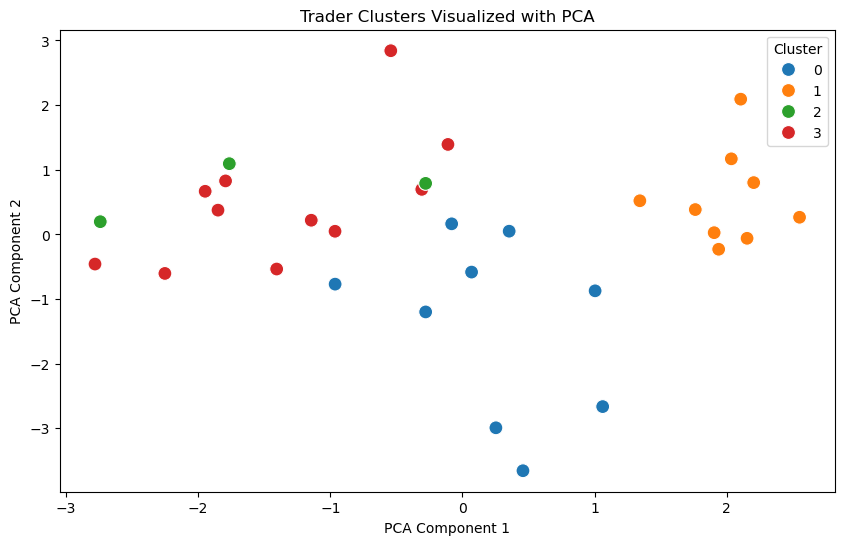

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=trader_features["cluster"], palette="tab10", s=100)
plt.title("Trader Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()
